# Tiny Imagenet

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import shutil, timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [3]:
from fastprogress import progress_bar
from glob import glob

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [5]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [6]:
path = Path('/workspace/ml_env/nbs')/'data'/'tiny-imagenet-200'
bs = 512
# bs = 32
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [7]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [8]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

In [9]:
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [10]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [11]:
xb,yb = next(iter(dls.train))

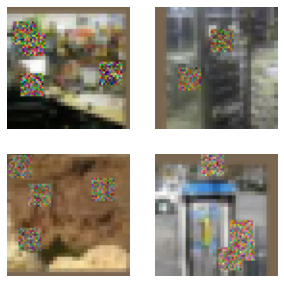

In [12]:
show_images(denorm(xb[:4]), imsize=2.5)

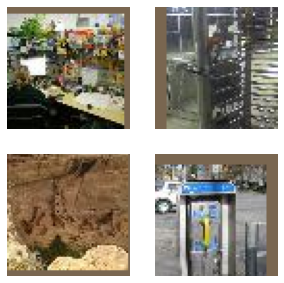

In [13]:
show_images(denorm(yb[:4]), imsize=2.5)

## Denoising autoencoder

In [14]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [15]:
def get_model(act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [16]:
iw = partial(init_weights, leaky=0.1)

In [17]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

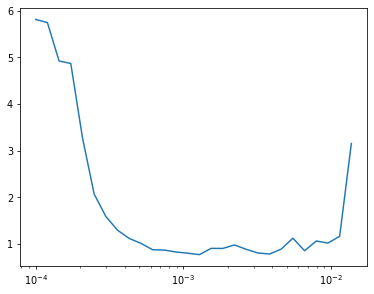

In [18]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [19]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.598,0,train
0.359,0,eval
0.315,1,train
0.277,1,eval
0.251,2,train
0.225,2,eval
0.226,3,train
0.209,3,eval
0.218,4,train
0.205,4,eval


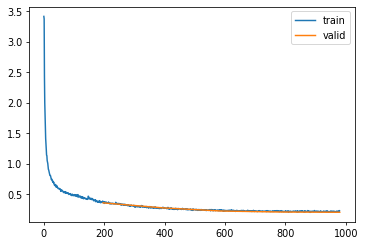

In [20]:
learn.fit(epochs)

loss,epoch,train
0.205,0,eval


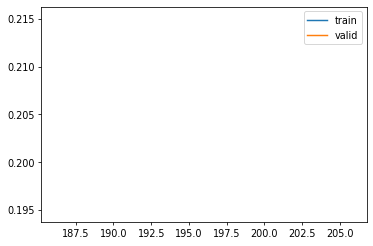

In [21]:
p,t,inp = learn.capture_preds(inps=True)

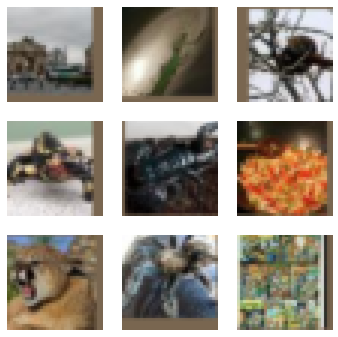

In [22]:
show_images(denorm(inp[:9]), imsize=2)

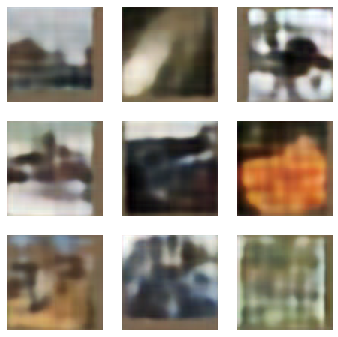

In [23]:
show_images(denorm(p[:9]), imsize=2)

## Unet

In [24]:
del(learn)
clean_mem()

In [25]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [26]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [27]:
model = TinyUnet()

In [28]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

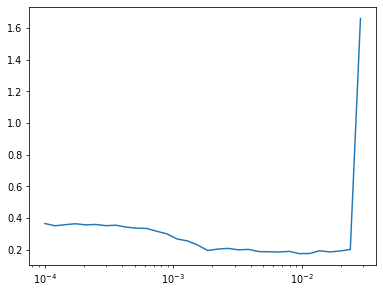

In [29]:
Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [30]:
model = TinyUnet()

In [31]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [32]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.161,0,train
0.081,0,eval
0.100,1,train
0.075,1,eval
0.090,2,train
0.074,2,eval
0.086,3,train
0.071,3,eval
0.084,4,train
0.071,4,eval


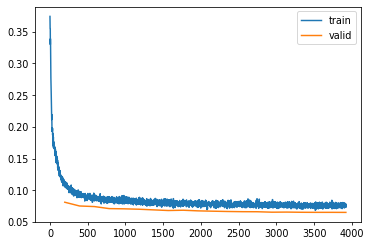

In [33]:
learn.fit(epochs)

loss,epoch,train
0.065,0,eval


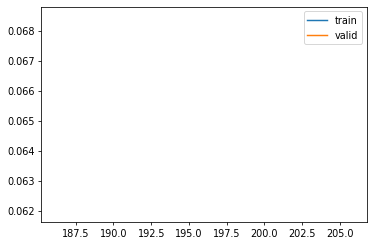

In [34]:
p,t,inp = learn.capture_preds(inps=True)

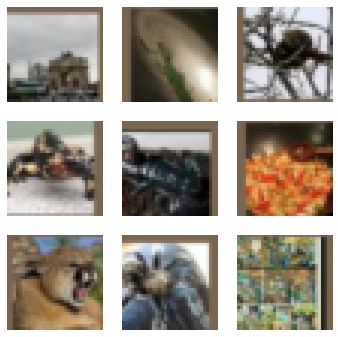

In [35]:
show_images(denorm(inp[:9]), imsize=2)

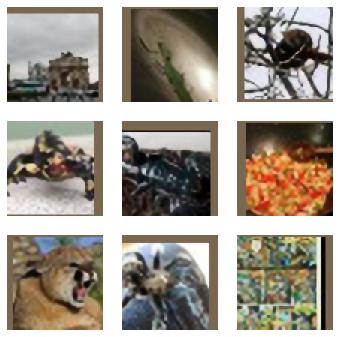

In [36]:
show_images(denorm(p[:9]), imsize=2)

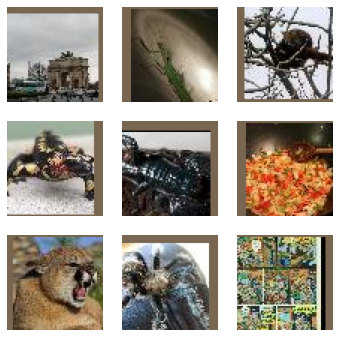

In [37]:
show_images(denorm(t[:9]), imsize=2)

## Perceptual loss

In [38]:
# del(learn)
# clean_mem()

In [39]:
cmodel = torch.load('models/inettiny-custom-25.pkl', weights_only=False).cuda()

In [40]:
xb,yb = next(iter(dls.valid))
with torch.autocast('cuda'),torch.no_grad(): preds = to_cpu(cmodel(yb.cuda().half()))
preds.shape

torch.Size([1024, 200])

In [41]:
id2str = (path/'wnids.txt').read_text().splitlines()
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

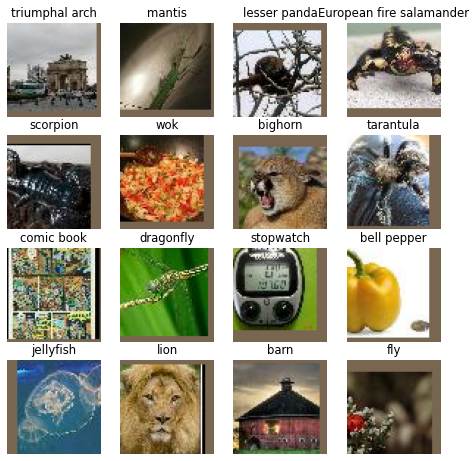

In [42]:
titles = [synsets[id2str[o]] for o in preds.argmax(dim=1)]
show_images(denorm(yb[:16]), imsize=2, titles=titles[:16])

In [43]:
for i in range(4,len(cmodel)): del(cmodel[4])

In [44]:
#learn.model = torch.load('models/superres-cross.pkl')

In [45]:
with torch.autocast('cuda'),torch.no_grad():
    feat = to_cpu(cmodel(yb.cuda())).float()
    t = to_cpu(learn.model(yb.cuda())).float()
    pred_feat = to_cpu(cmodel(t.cuda())).float()

feat.shape

torch.Size([1024, 256, 8, 8])

In [46]:
def comb_loss(inp, tgt):
    with torch.autocast('cuda'):
        with torch.no_grad(): tgt_feat = cmodel(tgt).float()
        inp_feat = cmodel(inp).float()
    feat_loss = F.mse_loss(inp_feat, tgt_feat)
    return F.mse_loss(inp,tgt) + feat_loss/10

In [47]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

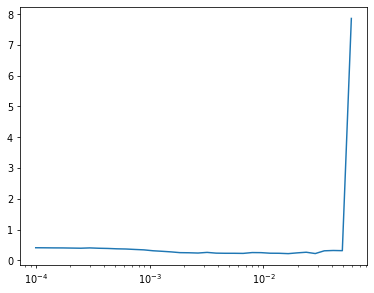

In [48]:
Learner(get_unet(), dls, comb_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [49]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.193,0,train
0.106,0,eval
0.128,1,train
0.098,1,eval
0.115,2,train
0.095,2,eval
0.110,3,train
0.093,3,eval
0.107,4,train
0.094,4,eval


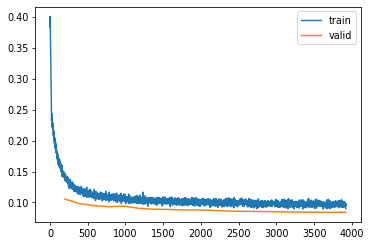

In [50]:
learn.fit(epochs)

loss,epoch,train
0.084,0,eval


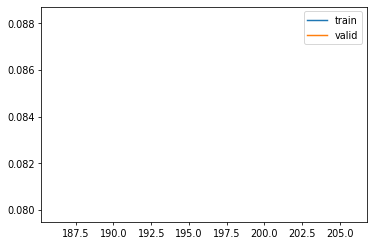

In [51]:
p,t,inp = learn.capture_preds(inps=True)

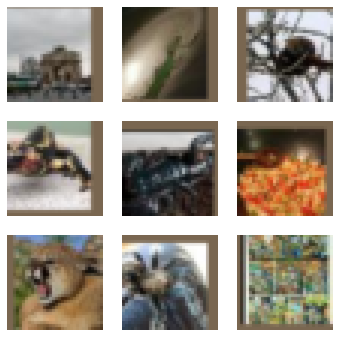

In [52]:
show_images(denorm(inp[:9]), imsize=2)

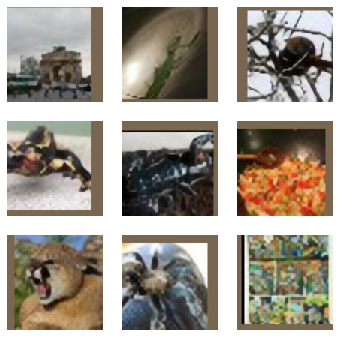

In [53]:
show_images(denorm(p[:9]), imsize=2)

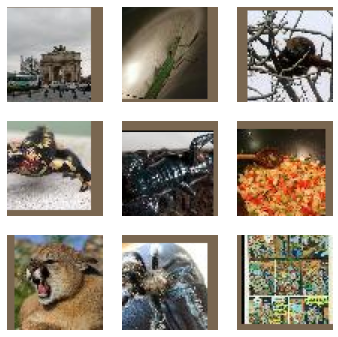

In [54]:
show_images(denorm(t[:9]), imsize=2)

## Perceptual loss

In [66]:
clean_mem()

In [67]:
model = get_unet()

In [68]:
pmodel = torch.load('models/inettiny-custom-25.pkl', weights_only=False)
model.start.load_state_dict(pmodel[0].state_dict()) 
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict())

In [69]:
for o in model.dn.parameters(): o.requires_grad_(False)

In [70]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

In [73]:
import gc

print("Clearing CUDA cache...")
torch.cuda.empty_cache()
gc.collect()
torch.cuda.synchronize()


if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        allocated = torch.cuda.memory_allocated(i) / 1024**3
        reserved = torch.cuda.memory_reserved(i) / 1024**3
        total = torch.cuda.get_device_properties(i).total_memory / 1024**3
        print(f"GPU {i}: {allocated:.2f}GB allocated / {reserved:.2f}GB reserved / {total:.2f}GB total")

Clearing CUDA cache...
GPU 0: 0.66GB allocated / 3.37GB reserved / 31.36GB total


In [75]:
# import os, signal, subprocess
# pids = [22622, 58528]
# for pid in pids:
#     try:
#         subprocess.run(['kill', '-9', str(pid)], check=False)
#         print(f"Killed process {pid}")
#     except:
#         print(f"Could not kill {pid} (may already be gone)")

Killed process 22622
Killed process 58528


loss,epoch,train
0.280,0,train
0.148,0,eval


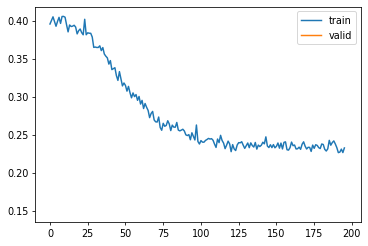

In [76]:
learn.fit(epochs)

In [77]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [78]:
epochs = 20
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.232,0,train
0.145,0,eval
0.230,1,train
0.143,1,eval
0.227,2,train
0.139,2,eval
0.222,3,train
0.134,3,eval
0.215,4,train
0.132,4,eval


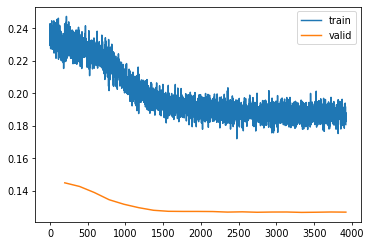

In [79]:
learn.fit(epochs)

In [80]:
torch.save(learn.model, 'models/superres-pcp.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()

loss,epoch,train
0.127,0,eval


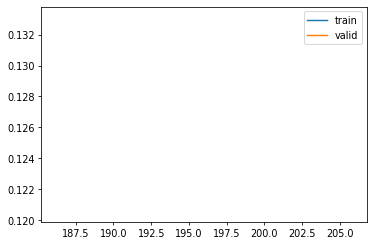

In [81]:
p,t,inp = learn.capture_preds(inps=True)

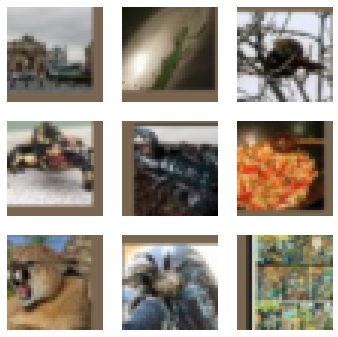

In [82]:
show_images(denorm(inp[:9]), imsize=2)

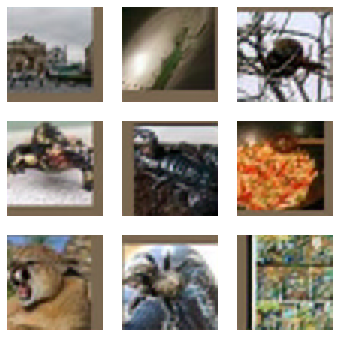

In [83]:
show_images(denorm(p[:9]), imsize=2)

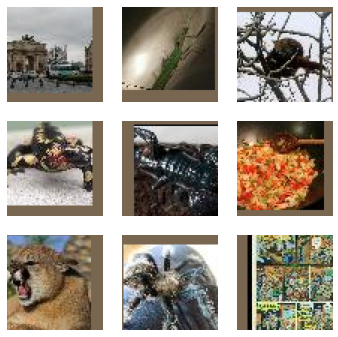

In [84]:
show_images(denorm(t[:9]), imsize=2)

In [85]:
torch.save(learn.model, 'models/superres-pcp.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()

## Cross-convs

### Evaluate new TinyUnet before first pmodel load

In [86]:
def cross_conv(nf, act, norm):
    return nn.Sequential(
        ResBlock(nf, nf, act=act, norm=norm),
        nn.Conv2d(nf, nf, 3, padding=1)
    )

In [87]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.xs = nn.ModuleList([cross_conv(nfs[i], act, norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.xs += [cross_conv(nfs[0], act, norm)]
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for i,l in enumerate(self.dn):
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += self.xs[i](layers[n-i])
            x = l(x)
        return self.end(x+layers[0])

In [88]:
pmodel = torch.load('models/inettiny-custom-25.pkl', weights_only=False)

In [89]:
model = get_unet()

In [91]:
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict())
for o in model.dn.parameters(): o.requires_grad_(False)

In [92]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.283,0,train
0.154,0,eval


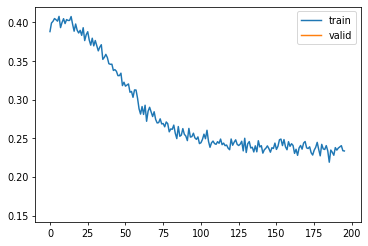

In [93]:
learn.fit(epochs)

In [94]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [95]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.235,0,train
0.150,0,eval
0.230,1,train
0.146,1,eval
0.217,2,train
0.136,2,eval
0.203,3,train
0.131,3,eval
0.196,4,train
0.130,4,eval


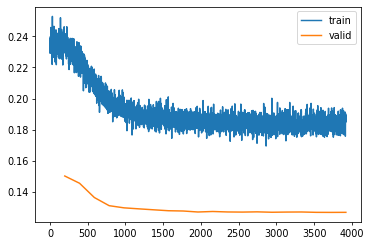

In [96]:
learn.fit(epochs)

loss,epoch,train
0.127,0,eval


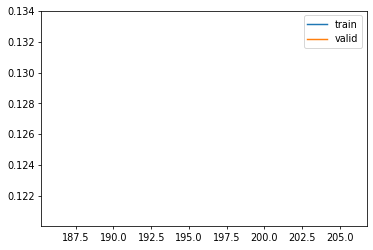

In [97]:
p,t,inp = learn.capture_preds(inps=True)

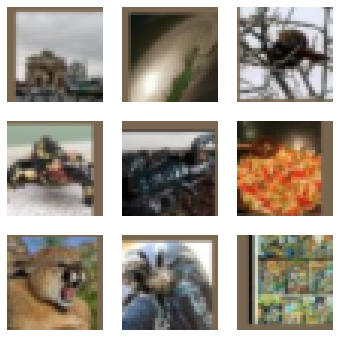

In [98]:
show_images(denorm(inp[:9]), imsize=2)

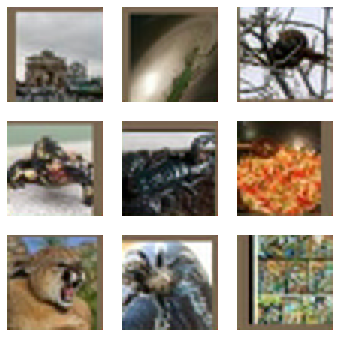

In [99]:
show_images(denorm(p[:9]), imsize=2)

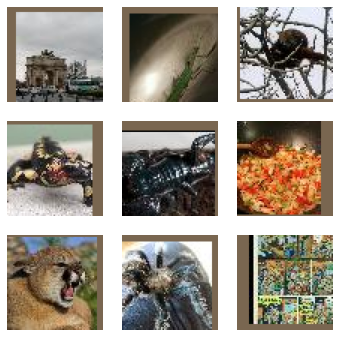

In [100]:
show_images(denorm(t[:9]), imsize=2)

In [101]:
torch.save(learn.model, 'models/superres-cross.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()